In [ ]:
using Pkg             # Load the package manager

# ONLY RUN THIS IF YOU HAVE DIFFERENT VERSIONS OF THE PACKAGES BELOW INSTALLED
# This creates a new environment in the current working directory
#
# Pkg.activate(".")

# Install the packages we need
Pkg.add([ "Catalyst", "DifferentialEquations", "Plots", "Random", "Distributions" ])

In [2]:
using Catalyst

In [23]:
# Initial set up using Catalyst.jl
# Three cell states: stem (proliferative) (S), quiescent (Q) and progenitor (P). 
# Four distinct assumptions (same underlying network structure, with different parameters set to zero):
# 1. No quiescence or de-differentiation: λ_SQ = 0; λ_PS = 0
# 2. Quiescence only: λ_PS = 0
# 3. De-differentiation only: λ_SQ = 0;
# 4. Quiescence and de-differentiation possible
stem_network = @reaction_network begin
    μ_S, S --> 0        # stem cell death 
    μ_Q, Q --> 0        # quiescent cell death
    μ_P, P --> 0        # progenitor cell death 
    σ_S, S --> 2*S      # stem cell division 
    2*σ_S/K, 2*S --> S  # incorporating carrying capacity (assume share between cell types?)
    σ_P, P --> 2*P      # progenitor cell division 
    2*σ_P/K, 2*P --> P  # incorporating carrying capacity (assume share between cell types?)
    λ_SQ, S --> Q       # proliferative stem cell -> quiescence
    λ_QS, Q --> S       # quiescent stem cell returning to proliferative state
    λ_SP, S --> P       # stem cell -> progenitor cell
    λ_PS, P --> S       # de-differentiation
end

Model ##ReactionSystem#271:
Unknowns (3): see unknowns(##ReactionSystem#271)
  S(t)
  Q(t)
  P(t)
Parameters (10): see parameters(##ReactionSystem#271)
  μ_S
  μ_Q
  μ_P
  σ_S
  ⋮

In [26]:
osys = convert(ODESystem, stem_network)

Model ##ReactionSystem#271:
Equations (3):
  3 standard: see equations(##ReactionSystem#271)
Unknowns (3): see unknowns(##ReactionSystem#271)
  S(t)
  Q(t)
  P(t)
Parameters (10): see parameters(##ReactionSystem#271)
  μ_S
  μ_Q
  μ_P
  σ_S
  ⋮

# No quiescence or de-differentiation

In [ ]:
# Model parameters and values
model_1_p = [ :μ_S => 0.1, 
      :μ_Q => 0.05,     # quiescent cells die at a lower rate than proliferative cells
      :μ_P => 0.25,     # progenitor cells die at a higher rate than stem cells
      :σ_S => 0.2,
      :σ_P => 0.25,     # progenitor cells proliferate at a higher rate than stem cells
      :λ_SQ => 0.0,     # Model 1: no quiescence
      :λ_QS => 0.0,     # Model 1: no quiescence
      :λ_SP => 0.1,     
      :λ_PS => 0.0,     # Model 1: no de-differentiation
      :K => 1000        # Setting a low carrying capacity initially for computational purposes 
      ]

# Initial conditions
u0 = [ :S => 1, :Q => 0, :P => 0 ]

# Simulation length
tmax = 100.0;

In [43]:
# Solve the corresponding ODEs (okay for large numbers of cells)
using DifferentialEquations

prob = ODEProblem(stem_network, u0, (0, tmax), model_1_p)
sol = solve(prob);

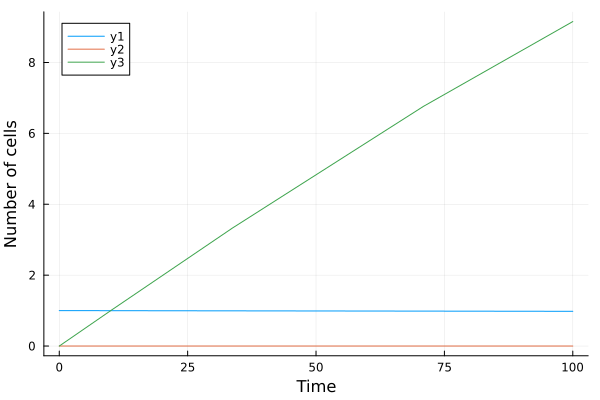

In [44]:
using Plots

plot(sol.t, sol[:S], 
     xlabel="Time", 
     ylabel="Number of cells")

plot!(sol.t, sol[:Q])
plot!(sol.t, sol[:P])

In [45]:
# Set up the stochastic version of the problem and solve for one instance
jinp = JumpInputs(stem_network, u0, (0, tmax), model_1_p)
prob = JumpProblem(jinp);
sol = solve(prob);

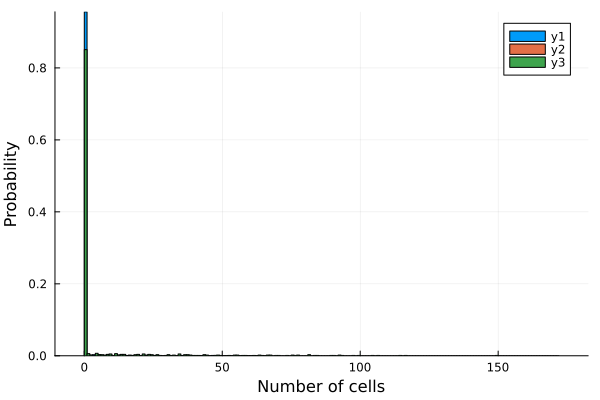

In [47]:
# Array to store the result of each simulation
ns = []
nq = []
np = []
# Number of simulations to perform
n_trajectories = 1000

for i in 1:n_trajectories
    sol = solve(prob)
    s = sol(tmax, idxs=:S) # record the number of stem cells at time t = tmax
    push!(ns, s)
    q = sol(tmax, idxs=:Q) # record the number of quiescent cells at time t = tmax
    push!(nq, q)
    p = sol(tmax, idxs=:P) # record the number of progenitor cells at time t = tmax
    push!(np, p)
end

# Compute and plot the discrete probability distribution
histogram(ns, 
          bins=0:maximum(ns), # define bins from 0 to the maximum observed number of stem cells
          normalize=:probability,
          xlabel="Number of cells", 
          ylabel="Probability") 

histogram!(nq,
          bins=0:maximum(nq), # define bins from 0 to the maximum observed number of quiescent cells
          normalize=:probability)

histogram!(np,
          bins=0:maximum(np), # define bins from 0 to the maximum observed number of progenitor cells
          normalize=:probability)

# Quiescence only

In [48]:
# Model parameters and values
model_2_p = [ :μ_S => 0.1, 
      :μ_Q => 0.05,     # quiescent cells die at a lower rate than proliferative cells
      :μ_P => 0.25,     # progenitor cells die at a higher rate than stem cells
      :σ_S => 0.2,
      :σ_P => 0.25,     # progenitor cells proliferate at a higher rate than stem cells
      :λ_SQ => 0.1,     
      :λ_QS => 0.1,     
      :λ_SP => 0.1,     
      :λ_PS => 0.0,     # Model 2: no de-differentiation
      :K => 1000        # Setting a low carrying capacity initially for computational purposes 
      ]

# Initial conditions
u0 = [ :S => 1, :Q => 0, :P => 0 ]

# Simulation length
tmax = 100.0;

In [49]:
# Solve the corresponding ODEs (okay for large numbers of cells)
using DifferentialEquations

prob = ODEProblem(stem_network, u0, (0, tmax), model_2_p)
sol = solve(prob);

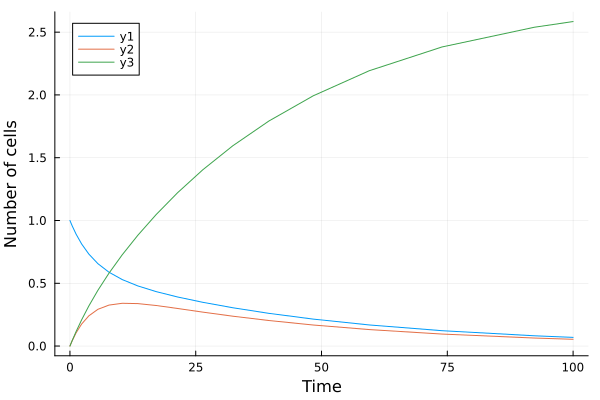

In [50]:
using Plots

plot(sol.t, sol[:S], 
     xlabel="Time", 
     ylabel="Number of cells")

plot!(sol.t, sol[:Q])
plot!(sol.t, sol[:P])

In [51]:
# Set up the stochastic version of the problem and solve for one instance
jinp = JumpInputs(stem_network, u0, (0, tmax), model_2_p)
prob = JumpProblem(jinp);
sol = solve(prob);

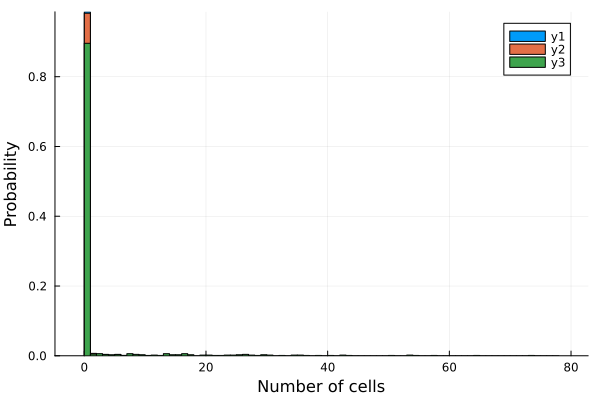

In [52]:
# Array to store the result of each simulation
ns = []
nq = []
np = []
# Number of simulations to perform
n_trajectories = 1000

for i in 1:n_trajectories
    sol = solve(prob)
    s = sol(tmax, idxs=:S) # record the number of stem cells at time t = tmax
    push!(ns, s)
    q = sol(tmax, idxs=:Q) # record the number of quiescent cells at time t = tmax
    push!(nq, q)
    p = sol(tmax, idxs=:P) # record the number of progenitor cells at time t = tmax
    push!(np, p)
end

# Compute and plot the discrete probability distribution
histogram(ns, 
          bins=0:maximum(ns), # define bins from 0 to the maximum observed number of stem cells
          normalize=:probability,
          xlabel="Number of cells", 
          ylabel="Probability") 

histogram!(nq,
          bins=0:maximum(nq), # define bins from 0 to the maximum observed number of quiescent cells
          normalize=:probability)

histogram!(np,
          bins=0:maximum(np), # define bins from 0 to the maximum observed number of progenitor cells
          normalize=:probability)

# De-differentiation only

In [55]:
# Model parameters and values
model_3_p = [ :μ_S => 0.1, 
      :μ_Q => 0.05,     # quiescent cells die at a lower rate than proliferative cells
      :μ_P => 0.25,     # progenitor cells die at a higher rate than stem cells
      :σ_S => 0.2,
      :σ_P => 0.25,     # progenitor cells proliferate at a higher rate than stem cells
      :λ_SQ => 0.0,     # Model 3: no quiescence
      :λ_QS => 0.0,     # Model 3: no quiescence
      :λ_SP => 0.1,     
      :λ_PS => 0.1,     
      :K => 1000        # Setting a low carrying capacity initially for computational purposes 
      ]

# Initial conditions
u0 = [ :S => 1, :Q => 0, :P => 0 ]

# Simulation length
tmax = 100.0;

In [56]:
# Solve the corresponding ODEs (okay for large numbers of cells)
using DifferentialEquations

prob = ODEProblem(stem_network, u0, (0, tmax), model_3_p)
sol = solve(prob);

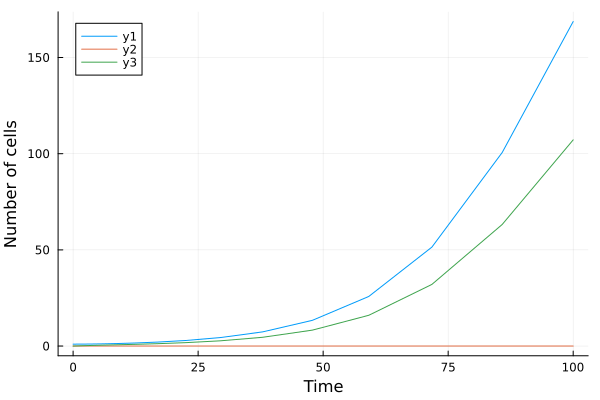

In [57]:
using Plots

plot(sol.t, sol[:S], 
     xlabel="Time", 
     ylabel="Number of cells")

plot!(sol.t, sol[:Q])
plot!(sol.t, sol[:P])

In [58]:
# Set up the stochastic version of the problem and solve for one instance
jinp = JumpInputs(stem_network, u0, (0, tmax), model_3_p)
prob = JumpProblem(jinp);
sol = solve(prob);

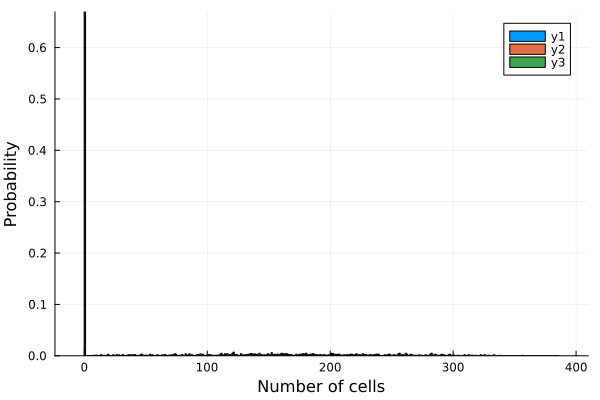

In [59]:
# Array to store the result of each simulation
ns = []
nq = []
np = []
# Number of simulations to perform
n_trajectories = 1000

for i in 1:n_trajectories
    sol = solve(prob)
    s = sol(tmax, idxs=:S) # record the number of stem cells at time t = tmax
    push!(ns, s)
    q = sol(tmax, idxs=:Q) # record the number of quiescent cells at time t = tmax
    push!(nq, q)
    p = sol(tmax, idxs=:P) # record the number of progenitor cells at time t = tmax
    push!(np, p)
end

# Compute and plot the discrete probability distribution
histogram(ns, 
          bins=0:maximum(ns), # define bins from 0 to the maximum observed number of stem cells
          normalize=:probability,
          xlabel="Number of cells", 
          ylabel="Probability") 

histogram!(nq,
          bins=0:maximum(nq), # define bins from 0 to the maximum observed number of quiescent cells
          normalize=:probability)

histogram!(np,
          bins=0:maximum(np), # define bins from 0 to the maximum observed number of progenitor cells
          normalize=:probability)

# Quiescence and de-differentiation

In [60]:
# Model parameters and values
model_4_p = [ :μ_S => 0.1, 
      :μ_Q => 0.05,     # quiescent cells die at a lower rate than proliferative cells
      :μ_P => 0.25,     # progenitor cells die at a higher rate than stem cells
      :σ_S => 0.2,
      :σ_P => 0.25,     # progenitor cells proliferate at a higher rate than stem cells
      :λ_SQ => 0.1,     
      :λ_QS => 0.1,     
      :λ_SP => 0.1,     
      :λ_PS => 0.1,     
      :K => 1000        # Setting a low carrying capacity initially for computational purposes 
      ]

# Initial conditions
u0 = [ :S => 1, :Q => 0, :P => 0 ]

# Simulation length
tmax = 100.0;

In [61]:
# Solve the corresponding ODEs (okay for large numbers of cells)
using DifferentialEquations

prob = ODEProblem(stem_network, u0, (0, tmax), model_4_p)
sol = solve(prob);

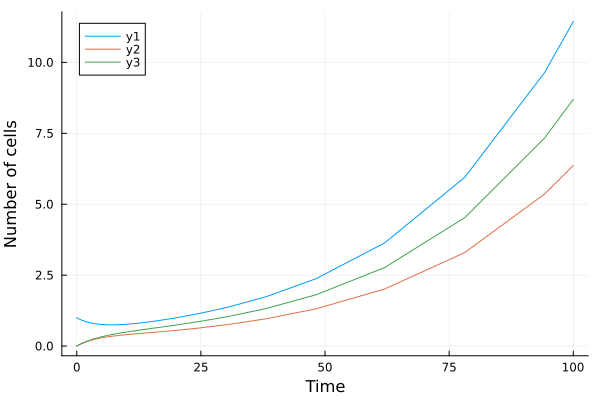

In [62]:
using Plots

plot(sol.t, sol[:S], 
     xlabel="Time", 
     ylabel="Number of cells")

plot!(sol.t, sol[:Q])
plot!(sol.t, sol[:P])

In [63]:
# Set up the stochastic version of the problem and solve for one instance
jinp = JumpInputs(stem_network, u0, (0, tmax), model_4_p)
prob = JumpProblem(jinp);
sol = solve(prob);

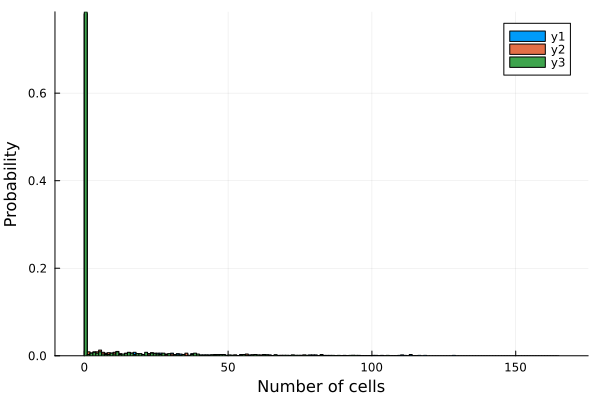

In [64]:
# Array to store the result of each simulation
ns = []
nq = []
np = []
# Number of simulations to perform
n_trajectories = 1000

for i in 1:n_trajectories
    sol = solve(prob)
    s = sol(tmax, idxs=:S) # record the number of stem cells at time t = tmax
    push!(ns, s)
    q = sol(tmax, idxs=:Q) # record the number of quiescent cells at time t = tmax
    push!(nq, q)
    p = sol(tmax, idxs=:P) # record the number of progenitor cells at time t = tmax
    push!(np, p)
end

# Compute and plot the discrete probability distribution
histogram(ns, 
          bins=0:maximum(ns), # define bins from 0 to the maximum observed number of stem cells
          normalize=:probability,
          xlabel="Number of cells", 
          ylabel="Probability") 

histogram!(nq,
          bins=0:maximum(nq), # define bins from 0 to the maximum observed number of quiescent cells
          normalize=:probability)

histogram!(np,
          bins=0:maximum(np), # define bins from 0 to the maximum observed number of progenitor cells
          normalize=:probability)